<a href="https://colab.research.google.com/github/poponzu/Research/blob/master/Debug%E7%94%A8_LSTM_SAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <span style="color: red">実行前にデバッグモードであるかどうか、train_start, test_start, data_endの値, 学習回数epochsを確認！</span>

In [226]:
# debug = 1はデバック（動作確認用)
debug = 1

In [227]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
# データの範囲指定
if debug:
  train_start = 2000
  test_start = 2490
  data_end = 2500
else: 
  # train_start = 2000
  train_start = 0
  # test_start = 6500
  test_start = 10512+2629
  # data_end = 7000
  data_end = 17379

# 学習回数
if debug:
  epochs = 2
else:
  epochs = 25

In [229]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [230]:
import torch
import torch.nn as nn
# Standard Library
from statistics import mean

# Third Party
import torch
from torch.nn import MSELoss
import tqdm
import random
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from torchmetrics.functional import mean_absolute_error

In [231]:
# seed決定するためのコード
def seed_everything(seed=42):
    print('Setting Random Seed')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

Setting Random Seed


In [232]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")

In [233]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [234]:
Bike_data = data[['cnt','season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered']]

In [235]:
# fig, (axL, axM, axR) = plt.subplots(ncols=3, figsize=(20,5))

# axL.plot(Bike_data['cnt'], linewidth=2)
# axL.set_title('Number of Bike sharing cnt')
# axL.set_xlabel('2012/1/1-2012/12/31')
# axL.set_ylabel('cnt')
# axL.grid(True)
# axL.vlines(x=2000, ymin=0, ymax=1000, colors='red', linestyles='dotted')
# axL.vlines(x=6500, ymin=0, ymax=1000, colors='black', linestyles='dotted')
# axL.vlines(x=7000, ymin=0, ymax=1000, colors='red', linestyles='dotted')


# axM.plot(Bike_data['temp'], linewidth=2)
# axM.set_title('tempeture')
# axM.set_xlabel('2012/1/1-2012/12/31')
# axM.set_ylabel('temp')
# axM.grid(True)
# axM.vlines(x=2000, ymin=0, ymax=1, colors='red', linestyles='dotted')
# axM.vlines(x=6500, ymin=0, ymax=1, colors='black', linestyles='dotted')
# axM.vlines(x=7000, ymin=0, ymax=1, colors='red', linestyles='dotted')

# axR.plot(Bike_data['registered'], linewidth=2)
# axR.set_title('Number of registered')
# axR.set_xlabel('2012/1/1-2012/12/31')
# axR.set_ylabel('registered')
# axR.grid(True)
# axR.vlines(x=2000, ymin=0, ymax=800, colors='red', linestyles='dotted')
# axR.vlines(x=6500, ymin=0, ymax=800, colors='black', linestyles='dotted')
# axR.vlines(x=7000, ymin=0, ymax=800, colors='red', linestyles='dotted')

# fig.show()

In [236]:
# データ量を調節
# Bike_data = Bike_data[2000:7000]
Bike_data = Bike_data[train_start:data_end]

In [237]:
Bike_data = Bike_data.values.astype(float)
Bike_data.shape

(500, 15)

In [238]:
BIke_data = torch.from_numpy(Bike_data)

In [239]:
train_data_size = test_start - train_start
test_data_size = data_end - test_start

train_data = Bike_data[:-test_data_size]
test_data = Bike_data[-test_data_size:]

In [240]:
#train_dataの正規化
# データセットの正規化を行う。最小値0と最大値1の範囲で行う。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

In [241]:
# Tensor型に変換
train_data_normalized = torch.FloatTensor(train_data_normalized)

## モデル作成

In [242]:
class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, out_activ):
        super(Encoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):
        x = x.unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)
            elif self.out_activ and index == self.num_layers - 1:
                return self.out_activ(h_n).squeeze()

        return h_n.squeeze()


class Decoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ):
        super(Decoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [h_dims[-1]]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ = h_activ
        self.dense_matrix = nn.Parameter(
            torch.rand((layer_dims[-1], out_dim), dtype=torch.float),
            requires_grad=True
        )

    def forward(self, x, seq_len):
        x = x.repeat(seq_len, 1).unsqueeze(0)
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)

        return torch.mm(x.squeeze(), self.dense_matrix)


######
# MAIN
######


class LSTM_AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Sigmoid(),
                 out_activ=nn.Tanh()):
        super(LSTM_AE, self).__init__()

        self.encoder = Encoder(input_dim, encoding_dim, h_dims, h_activ,
                               out_activ)
        self.decoder = Decoder(encoding_dim, input_dim, h_dims[::-1],
                               h_activ)

    def forward(self, x):
        # print(x)
        seq_len = x.shape[0]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)

        return x

    def __name__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Sigmoid(),
                 out_activ=nn.Tanh()):

        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.h_dims = h_dims
        self.h_activ = h_activ
        self.out_activ = out_activ

In [243]:
Bike_data.shape

(500, 15)

In [244]:
AE_model = LSTM_AE(
    input_dim=15,   # 入力列数に合わせる
    encoding_dim=10, # decordの時に使う最終的に何時限までに圧縮するか
    h_dims=[100],
    h_activ=None,
    out_activ=None
)

In [245]:
print(AE_model)

LSTM_AE(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(15, 100, batch_first=True)
      (1): LSTM(100, 10, batch_first=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(10, 100, batch_first=True)
      (1): LSTM(100, 100, batch_first=True)
    )
  )
)


In [246]:
def train_model(model, train_set, verbose, lr, epochs, denoise):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    mean_losses = []
    for epoch in tqdm.tqdm(range(1, epochs + 1)):
        model.train()

        # # Reduces learning rate every 50 epochs
        # if not epoch % 50:
        #     for param_group in optimizer.param_groups:
        #         param_group["lr"] = lr * (0.993 ** epoch)

        losses = []
        for x in train_set:
            optimizer.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)

        if verbose:
            print(f"Epoch: {epoch}, MSELoss: {mean_loss}")
    
    # 学習時の損失をグラフ表示
    plt.plot(mean_losses)

    return mean_losses


def get_encodings(model, train_set):
    model.eval()
    encodings = [model.encoder(x) for x in train_set]
    return encodings


# def instantiate_model(model, train_set, encoding_dim, **kwargs):
#     if model.__name__ in ("LINEAR_AE", "LSTM_AE"):
#         return model(train_set[-1].shape[-1], encoding_dim, **kwargs)
#     elif model.__name__ == "CONV_LSTM_AE":
#         if len(train_set[-1].shape) == 3: # 2D elements
#             return model(train_set[-1].shape[-2:], encoding_dim, **kwargs)
#         elif len(train_set[-1].shape) == 4: # 3D elements
#             return model(train_set[-1].shape[-3:], encoding_dim, **kwargs)



######
# MAIN
######


def quick_train(model, train_set, encoding_dim, verbose=False, lr=1e-3,
                epochs=1, denoise=False, **kwargs):
    # 確かめるために追加
    # print(list(model.parameters()))

    # model = instantiate_model(model, train_set, encoding_dim, **kwargs)
    # print(model)
    losses = train_model(model, train_set, verbose, lr, epochs, denoise)
    encodings = get_encodings(model, train_set)

    return model.encoder, model.decoder, encodings, losses

## AEの学習

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 1/2 [00:06<00:06,  6.38s/it]

Epoch: 1, MSELoss: 0.05717938107210307


100%|██████████| 2/2 [00:25<00:00, 12.59s/it]

Epoch: 2, MSELoss: 0.0570839202060003


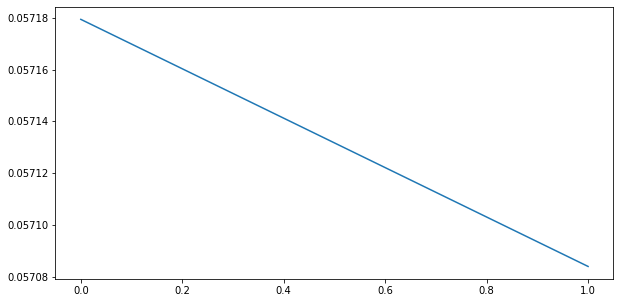

In [247]:
encoder, decoder, _, _ = quick_train(AE_model, train_data_normalized, verbose=True, epochs=epochs, encoding_dim=10)

## モデルの保存

In [248]:
if debug != 1:
  with open('/content/drive/MyDrive/Colab Notebooks/LSTM-SAE/made_model.pickle', mode='wb') as f:
      pickle.dump(AE_model, f , protocol=2)
  print("モデルの保存完了。")

In [249]:
AE_model.encoder

Encoder(
  (layers): ModuleList(
    (0): LSTM(15, 100, batch_first=True)
    (1): LSTM(100, 10, batch_first=True)
  )
)

## LSTM作成

In [250]:
# シーケンスに沿ったデータを作成する関数
def make_sequence_data(input_data, num_sequence):
    # シーケンスデータとラベルデータの器
    data = []
    # 全体のデータ数取得
    num_data = len(input_data)
    # 全体からシーケンス分引いた数までループする
    for i in range(num_data - num_sequence):
        # 1個ずらして、シーケンス分のデータを取得していく
        seq_data = input_data[i:i+num_sequence]
        # シーケンスの次の要素のデータ(ラベルデータとして1個目の陽性者数のみ)を取得していく
        target_data = input_data[:,0][i+num_sequence:i+num_sequence+1]
        # シーケンスデータとラベルデータをタプルとして取得していく
        data.append((seq_data, target_data))

    return data
  
# シーケンス長は24データとする
# 24時間分のデータから次の1日後のデータを予測する
# 48時間とかにしてもよいかも
seq_length = 24
# train_seq_data=最初のデータを1個ずらしてシーケンス分のデータ(時系列の学習データ群)、train_target=train_seq_dataの次のデータ(ラベルデータ)
train_seq_data = make_sequence_data(train_data_normalized, seq_length)

In [251]:
class LSTM(nn.Module):
    def __init__(self, input_size=15, hidden_layer_size=100, output_size=1, num_layers=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.1)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [252]:
AE_model

LSTM_AE(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(15, 100, batch_first=True)
      (1): LSTM(100, 10, batch_first=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(10, 100, batch_first=True)
      (1): LSTM(100, 100, batch_first=True)
    )
  )
)

In [253]:
class LSTM_SAE(nn.Module):
    def __init__(self, input_size=15, hidden_layer_size=100, output_size=1, num_layers=2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.1)
        self.lstm = AE_model.encoder

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction

In [254]:
device = 'cpu'

In [255]:
SAE_model = LSTM_SAE()
SAE_model.to(device)

LSTM_SAE(
  (lstm): Encoder(
    (layers): ModuleList(
      (0): LSTM(15, 100, batch_first=True)
      (1): LSTM(100, 10, batch_first=True)
    )
  )
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [256]:
# 損失関数と最適化関数を定義
criterion = nn.MSELoss()
optimizer = optim.AdamW(SAE_model.parameters(), lr=0.001)

In [257]:
# 予測する日数
pred_days = test_data_size
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()

# t_dataの用意
t_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")
t_data = t_data["cnt"][test_start:data_end]
t_data = t_data.values.astype(np.float32)
t_data = torch.from_numpy(t_data)

In [258]:
import tqdm

train_losses = []
test_losses = []

for epoch in tqdm.tqdm(range(epochs)):
    SAE_model.train()
    for seq, labels in train_seq_data:
        # seq, labelsのshapeは(seq_length, 特徴量)なのでLSTMに渡すために(batch, seq_length, 特徴量)にする。(batch=1)
        seq, labels = torch.unsqueeze(seq, 0), torch.unsqueeze(labels, 0)
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = SAE_model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    train_losses.append(single_loss.item())
    # print(f'epoch: {i}, train_loss : {single_loss.item()}')

    # testデータに対する予測の損失計算
    # モデルを評価モードとする
    model.eval()
    # 予測値を入れるリスト
    test_outputs = []
    for i in range(pred_days):
        seq = torch.FloatTensor(test_inputs[-seq_length:])
        seq = torch.unsqueeze(seq, 0)
        seq = seq.to(device)
        with torch.no_grad():
            test_inputs.append(test_data_normalized.tolist()[i])
            test_outputs.append(SAE_model(seq).item())

    np_test_outputs = np.array(test_outputs).reshape(-1,1)
    # 列方向に同じ値を追加して(?, 15)にする
    np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
    np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
    np_test_outputs4 = np.hstack((np_test_outputs3, np_test_outputs))
    np_test_outputs5 = np.hstack((np_test_outputs4, np_test_outputs))
    np_test_outputs6 = np.hstack((np_test_outputs5, np_test_outputs))
    np_test_outputs7 = np.hstack((np_test_outputs6, np_test_outputs))
    np_test_outputs8 = np.hstack((np_test_outputs7, np_test_outputs))
    np_test_outputs9 = np.hstack((np_test_outputs8, np_test_outputs))
    np_test_outputs10 = np.hstack((np_test_outputs9, np_test_outputs))
    np_test_outputs11 = np.hstack((np_test_outputs10, np_test_outputs))
    np_test_outputs12 = np.hstack((np_test_outputs11, np_test_outputs))
    np_test_outputs13 = np.hstack((np_test_outputs12, np_test_outputs))
    np_test_outputs14 = np.hstack((np_test_outputs13, np_test_outputs))
    np_test_outputs15 = np.hstack((np_test_outputs14, np_test_outputs))

    actual_predictions = scaler.inverse_transform(np_test_outputs15)


    predictions = torch.from_numpy(actual_predictions[:,0])
    test_criterion = nn.MSELoss()
    test_loss = test_criterion(t_data, predictions)
    print(f'epoch: {epoch}, train_loss : {single_loss.item()}, test_loss : {test_loss}')
    test_losses.append(test_loss)

  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
#trainデータに対する予測の損失をグラフ表示
plt.title('train_loss')
plt.plot(train_losses)

In [ ]:
# testデータに対する予測の損失をグラフ表示
plt.title('test_loss')
plt.plot(test_losses)

In [ ]:
# 予測する日数
pred_days = test_data_size
# テストデータの正規化を行う。最小値0と最大値1の範囲で行ってTensor型に変換する。
test_data_normalized = scaler.fit_transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)
# 予測するためのデータの最初のseq_length分はtrain_dataを使う
test_inputs = train_data_normalized[-seq_length:].tolist()

In [ ]:
# モデルを評価モードとする
SAE_model.eval()
# 予測値を入れるリスト
test_outputs = []
for i in tqdm.tqdm(range(pred_days)):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    seq = torch.unsqueeze(seq, 0)
    seq = seq.to(device)
    with torch.no_grad():
        test_inputs.append(test_data_normalized.tolist()[i])
        test_outputs.append(model(seq).item())

In [ ]:
np_test_outputs = np.array(test_outputs).reshape(-1,1)
# 列方向に同じ値を追加して(-1, 15)にする
np_test_outputs2 = np.hstack((np_test_outputs, np_test_outputs))
np_test_outputs3 = np.hstack((np_test_outputs2, np_test_outputs))
np_test_outputs4 = np.hstack((np_test_outputs3, np_test_outputs))
np_test_outputs5 = np.hstack((np_test_outputs4, np_test_outputs))
np_test_outputs6 = np.hstack((np_test_outputs5, np_test_outputs))
np_test_outputs7 = np.hstack((np_test_outputs6, np_test_outputs))
np_test_outputs8 = np.hstack((np_test_outputs7, np_test_outputs))
np_test_outputs9 = np.hstack((np_test_outputs8, np_test_outputs))
np_test_outputs10 = np.hstack((np_test_outputs9, np_test_outputs))
np_test_outputs11 = np.hstack((np_test_outputs10, np_test_outputs))
np_test_outputs12 = np.hstack((np_test_outputs11, np_test_outputs))
np_test_outputs13 = np.hstack((np_test_outputs12, np_test_outputs))
np_test_outputs14 = np.hstack((np_test_outputs13, np_test_outputs))
np_test_outputs15 = np.hstack((np_test_outputs14, np_test_outputs))

actual_predictions = scaler.inverse_transform(np_test_outputs15)

# 図示のための準備

In [ ]:
# 予測値のx軸の値の設定
x = np.arange(test_start, data_end, 1)
print(x,test_data_size)

In [ ]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

In [ ]:
plt.title('Number of cnt')
plt.ylabel('cnt')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['cnt'], label='Ground Truth')
plt.plot(x, actual_predictions[:,0], label='Prediction')
plt.xlabel('2011/1/1 - 2012/12/31')
plt.legend()
plt.vlines(x=train_start, ymin=0, ymax=1000, colors='red', linestyles='dotted')
plt.vlines(x=test_start, ymin=0, ymax=1000, colors='black', linestyles='dotted')
plt.vlines(x=data_end, ymin=0, ymax=1000, colors='red', linestyles='dotted')
plt.show()

In [ ]:
plt.title('Bike sharing data')
plt.ylabel('cnt in 1 hour')
plt.grid(True)
plt.plot(data["cnt"][test_start:data_end], label='Ground Truth')
plt.plot(x,actual_predictions[:,0], label='Prediction')
plt.legend()
plt.show()

## 損失の値を出す

In [ ]:
t_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM-AE/Bike_sharing_predict/Bike-Sharing-Dataset/hour.csv")
t_data = t_data["cnt"][test_start:data_end]
t_data = t_data.values.astype(np.float32)
t_data = torch.from_numpy(t_data)
predicitions = torch.from_numpy(actual_predictions[:,0])

MSE_criterion = nn.MSELoss()
MSE_loss = MSE_criterion(t_data, predictions)

MAE_loss =  mean_absolute_error(t_data, predictions)

print(f'MSEの値は: {MSE_loss} です')
print(f'RMSEの値は: {torch.sqrt(MSE_loss)} です')
print(f'MAEの値は: {MAE_loss} です')